In [1]:
!pip install torch==1.13.1+cu116 
!pip install torchvision==0.14.1+cu116
!pip install faiss-cpu==1.7.3
!pip install pytorch-lightning==1.9.4
!pip install pytorch-metric-learning==2.0.1
!pip install opencv-python==4.7.0.72
!pip install scikit-image==0.19.3
!conda install -y gdown

ERROR: Could not find a version that satisfies the requirement torch==1.13.1+cu116 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1)
ERROR: No matching distribution found for torch==1.13.1+cu116
ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.15.0
ERROR: Could not find a version that satisfies the requirement torchvision==0.14.1+cu116 (from versions: 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2, 0.18.0, 0.18.1)
ERROR: No matching distribution found for torchvision==0.14.1+cu116
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 55.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 kB 5.2 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.3.3
    Uninstalling pytorch-ligh

In [49]:
# Libraries

import os
import faiss
import torch
import numpy as np
import torch.nn as nn
import torchvision.models
import pytorch_lightning as pl
from typing import Tuple
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from pytorch_metric_learning import losses
from torchvision import transforms as tfm
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers
from glob import glob
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict

# Google libraries

import requests
import zipfile
import gdown

In [3]:
# Download and extract

zip_url_tokyo = 'https://drive.google.com/file/d/1FUSHfFUMcPyXMbzt9hKUoYoLZ_uEHULP/view?usp=drive_link' # tokyo
zip_url_sf = 'https://drive.google.com/file/d/10wCmksu4w1uMRnmDkTPvuVWq_u5nqHEQ/view?usp=drive_link' # sf
zip_url_gsv = 'https://drive.google.com/file/d/10QHcLRefihtVIFuLMxcnxDSi_6E4MBJs/view?usp=drive_link' # gsv

destination_folder = './dataset'

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)
    
def download_and_extract(zip_url, destination_folder):
    # Extract the file ID from the URL
    file_id = zip_url.split('/')[-2]
    
    # Create the direct download URL
    download_url = f'https://drive.google.com/uc?id={file_id}'
    
    # Download the zip file
    output_file = os.path.join(destination_folder, f'{file_id}.zip')
    gdown.download(download_url, output_file, quiet=False, fuzzy=True)
    
    # Extract the zip file
    with zipfile.ZipFile(output_file, 'r') as zip_ref:
        zip_ref.extractall(destination_folder)
    
    # Remove the downloaded zip file
    os.remove(output_file)
    
    print(f"Extraction completed for: {file_id}.zip")
    

download_and_extract(zip_url_tokyo, destination_folder)
download_and_extract(zip_url_sf, destination_folder)
download_and_extract(zip_url_gsv, destination_folder)

Downloading...
From (original): https://drive.google.com/uc?id=1FUSHfFUMcPyXMbzt9hKUoYoLZ_uEHULP
From (redirected): https://drive.google.com/uc?id=1FUSHfFUMcPyXMbzt9hKUoYoLZ_uEHULP&confirm=t&uuid=e8722c9c-9a43-420d-9d3c-24a282d3a738
To: /kaggle/working/dataset/1FUSHfFUMcPyXMbzt9hKUoYoLZ_uEHULP.zip
100%|██████████| 141M/141M [00:04<00:00, 31.3MB/s] 


Extraction completed for: 1FUSHfFUMcPyXMbzt9hKUoYoLZ_uEHULP.zip


Downloading...
From (original): https://drive.google.com/uc?id=10wCmksu4w1uMRnmDkTPvuVWq_u5nqHEQ
From (redirected): https://drive.google.com/uc?id=10wCmksu4w1uMRnmDkTPvuVWq_u5nqHEQ&confirm=t&uuid=29892ab1-2bd7-4452-b9f8-7a1c99ab71aa
To: /kaggle/working/dataset/10wCmksu4w1uMRnmDkTPvuVWq_u5nqHEQ.zip
100%|██████████| 1.03G/1.03G [00:14<00:00, 69.0MB/s]


Extraction completed for: 10wCmksu4w1uMRnmDkTPvuVWq_u5nqHEQ.zip


Downloading...
From (original): https://drive.google.com/uc?id=10QHcLRefihtVIFuLMxcnxDSi_6E4MBJs
From (redirected): https://drive.google.com/uc?id=10QHcLRefihtVIFuLMxcnxDSi_6E4MBJs&confirm=t&uuid=e116ac6d-b157-4c7c-94dd-91c2c612d069
To: /kaggle/working/dataset/10QHcLRefihtVIFuLMxcnxDSi_6E4MBJs.zip
100%|██████████| 5.67G/5.67G [01:16<00:00, 74.0MB/s]


Extraction completed for: 10QHcLRefihtVIFuLMxcnxDSi_6E4MBJs.zip


In [50]:
def open_image(path):
    return Image.open(path).convert("RGB")

transform = tfm.Compose([
    tfm.ToTensor(),
    tfm.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [51]:
class TrainDataset(Dataset):
    def __init__(self, dataset_folder, transform, img_per_place=4, min_img_per_place=4):
        super().__init__()
        self.dataset_folder = dataset_folder
        self.images_paths = sorted(glob(f"{dataset_folder}/**/*.jpg", recursive=True))
        self.dict_place_paths = defaultdict(list)
        
        for image_path in self.images_paths:
            place_id = image_path.split("@")[-2]
            self.dict_place_paths[place_id].append(image_path)

        assert img_per_place <= min_img_per_place, \
            f"img_per_place should be less than {min_img_per_place}"
        self.img_per_place = img_per_place
        self.transform = transform

        # keep only places depicted by at least min_img_per_place images
        for place_id in list(self.dict_place_paths.keys()):
            all_paths_from_place_id = self.dict_place_paths[place_id]
            if len(all_paths_from_place_id) < min_img_per_place:
                del self.dict_place_paths[place_id]
        self.places_ids = sorted(list(self.dict_place_paths.keys()))
        self.total_num_images = sum([len(paths) for paths in self.dict_place_paths.values()])

    def __getitem__(self, index):
        place_id = self.places_ids[index]
        all_paths_from_place_id = self.dict_place_paths[place_id]
        chosen_paths = np.random.choice(all_paths_from_place_id, self.img_per_place)
        images = [Image.open(path).convert('RGB') for path in chosen_paths]
        images = [self.transform(img) for img in images]
        return torch.stack(images), torch.tensor(index).repeat(self.img_per_place)

    def __len__(self):
        return len(self.places_ids)

In [52]:
# kaggle
train_dataset = TrainDataset('/kaggle/working/dataset/gsv_xs/train', transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, num_workers=2, shuffle=True)
print(f"Train dataset: {len(train_dataset)}")


Train dataset: 62514


In [54]:
class TestDataset(Dataset):
    def __init__(self, dataset_folder, database_folder="database", queries_folder="queries", positive_dist_threshold=25):
        super().__init__()
        self.dataset_folder = dataset_folder
        self.database_folder = os.path.join(dataset_folder, database_folder)
        self.queries_folder = os.path.join(dataset_folder, queries_folder)
        self.dataset_name = os.path.basename(dataset_folder)
        self.database_paths = sorted(glob(os.path.join(self.database_folder, "**", "*.jpg"), recursive=True))
        self.queries_paths = sorted(glob(os.path.join(self.queries_folder, "**", "*.jpg"),  recursive=True))

        # exteract UTM
        self.database_utms = np.array \
            ([(path.split("@")[1], path.split("@")[2]) for path in self.database_paths]).astype(float)
        self.queries_utms = np.array([(path.split("@")[1], path.split("@")[2]) for path in self.queries_paths]).astype \
            (float)

        # Find positives_per_query, which are within positive_dist_threshold
        knn = NearestNeighbors(n_jobs=-1)
        knn.fit(self.database_utms)
        self.positives_per_query = knn.radius_neighbors(self.queries_utms, radius=positive_dist_threshold, return_distance=False)

        self.images_paths = [p for p in self.database_paths]
        self.images_paths += [p for p in self.queries_paths]

        self.database_num = len(self.database_paths)
        self.queries_num = len(self.queries_paths)

    def __getitem__(self, index):
        image_path = self.images_paths[index]
        pil_img = open_image(image_path)
        normalized_img = transform(pil_img)
        return normalized_img, index

    def __len__(self):
        return len(self.images_paths)

    def __repr__(self):
        return f"< {self.dataset_name} - #q: {self.queries_num}; #db: {self.database_num} >"

    def get_positives(self):
        return self.positives_per_query

In [55]:
# kaggle
sf_val_dataset = TestDataset('/kaggle/working/dataset/sf_xs/val')
sf_test_dataset = TestDataset('/kaggle/working/dataset/sf_xs/test')
tokyo_test_dataset = TestDataset('/kaggle/working/dataset/tokyo_xs/test')

val_loader = DataLoader(dataset=sf_val_dataset, batch_size=64, num_workers=2, shuffle=False)
test_loader = DataLoader(dataset=sf_test_dataset, batch_size=64, num_workers=2, shuffle=False)
tokyo_loader = DataLoader(dataset=tokyo_test_dataset, batch_size=64, num_workers=2, shuffle=False)

print(f"val sf: {len(sf_val_dataset)}")
print(f"test sf: {len(sf_test_dataset)}")
print(f"test tokyo: {len(tokyo_test_dataset)}")

val sf: 16008
test sf: 28191
test tokyo: 13086


In [56]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super().__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)

    def gem(self, x, p=3, eps=1e-6):
        return nn.functional.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1.0 / p)

    def __repr__(self):
        return self.__class__.__name__ + f"(p={self.p.data.tolist()[0]:.4f}, eps={self.eps})"

In [57]:
def compute_recalls(eval_ds: Dataset, queries_descriptors : np.ndarray, database_descriptors : np.ndarray):

    # Use a kNN to find predictions
    faiss_index = faiss.IndexFlatL2(queries_descriptors.shape[1])
    faiss_index.add(database_descriptors)
    del database_descriptors

    print("Calculating")
    RECALL_VALUES = [1, 5]
    _, predictions = faiss_index.search(queries_descriptors, max(RECALL_VALUES))

    positives_per_query = eval_ds.get_positives()
    recalls = np.zeros(len(RECALL_VALUES))
    for query_index, preds in enumerate(predictions):
        for i, n in enumerate(RECALL_VALUES):
            if np.any(np.in1d(preds[:n], positives_per_query[query_index])):
                recalls[i:] += 1
                break
    # Divide by queries_num and multiply by 100, so the recalls are in percentages
    recalls = recalls / eval_ds.queries_num * 100
    recalls_str = ", ".join([f"R@{val}: {rec:.1f}" for val, rec in zip(RECALL_VALUES, recalls)])
    
    return recalls, recalls_str

In [58]:
# Step 2 - GeM with Adam

class LightningModel(pl.LightningModule):
    def __init__(self, val_dataset, test_dataset, descriptors_dim=512):
        super().__init__()
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        
        # Load pretrained ResNet-18
        resnet18 = torchvision.models.resnet18(pretrained=True)
        
        # Truncate the model at conv3 (end of layer2)
        self.features = torch.nn.Sequential(
            resnet18.conv1,
            resnet18.bn1,
            resnet18.relu,
            resnet18.maxpool,
            resnet18.layer1,
            resnet18.layer2,
        )
        
        # Replace average pooling with GeM pooling
        self.gem_pool = GeM()
    
        # Calculate the output dimension
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            output = self.gem_pool(self.features(dummy_input))
            self.output_dim = output.view(-1).shape[0]
    
        # Add a linear layer to match the desired descriptors dimension
        self.fc = torch.nn.Linear(self.output_dim, descriptors_dim)
    
        # Set the loss function
        self.loss_fn = losses.ContrastiveLoss(pos_margin=0, neg_margin=1)

    def forward(self, images):
        x = self.features(images)
        x = self.gem_pool(x)
        x = torch.flatten(x, 1)
        descriptors = self.fc(x)
        return descriptors
        

        
        
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer

    def loss_function(self, descriptors, labels):
        loss = self.loss_fn(descriptors, labels)
        return loss

    def training_step(self, batch, batch_idx):
        images, labels = batch
        num_places, num_images_per_place, C, H, W = images.shape
        images = images.view(num_places * num_images_per_place, C, H, W)
        labels = labels.view(num_places * num_images_per_place)

        descriptors = self(images)
        loss = self.loss_function(descriptors, labels)
        
        self.log('loss', loss.item(), logger=True)
        return {'loss': loss}

    def inference_step(self, batch):
        images, _ = batch
        descriptors = self(images)
        return descriptors.cpu().numpy().astype(np.float32)

    def validation_step(self, batch, batch_idx):
        return self.inference_step(batch)

    def test_step(self, batch, batch_idx):
        return self.inference_step(batch)

    def validation_epoch_end(self, all_descriptors):
        return self.inference_epoch_end(all_descriptors, self.val_dataset, 'val')

    def test_epoch_end(self, all_descriptors):
        return self.inference_epoch_end(all_descriptors, self.test_dataset, 'test')

    def inference_epoch_end(self, all_descriptors, inference_dataset, split):
        all_descriptors = np.concatenate(all_descriptors)
        queries_descriptors = all_descriptors[inference_dataset.database_num:]
        database_descriptors = all_descriptors[:inference_dataset.database_num]

        recalls, recalls_str = compute_recalls(inference_dataset, queries_descriptors, database_descriptors)

        print(f"Epoch[{self.current_epoch:02d}]): " +
                      f"recalls: {recalls_str}")

        self.log(f'{split}/R@1', recalls[0], prog_bar=False, logger=True)
        self.log(f'{split}/R@5', recalls[1], prog_bar=False, logger=True)

In [64]:
model = LightningModel(sf_val_dataset, sf_test_dataset)

checkpoint_cb = ModelCheckpoint(
    monitor='val/R@1',
    filename='_epoch({epoch:02d})_R@1[{val/R@1:.4f}]_R@5[{val/R@5:.4f}]',
    auto_insert_metric_name=False,
    save_weights_only=False,
    save_top_k=1,
    save_last=True,
    mode='max'
)

tb_logger = pl_loggers.TensorBoardLogger(save_dir="logs/", version="default")

trainer = pl.Trainer(
    accelerator='gpu',
    devices=[0],
    default_root_dir='./logs',
    num_sanity_val_steps=0,
    precision=16,
    max_epochs=1,
    check_val_every_n_epoch=1,
    logger=tb_logger,
    callbacks=[checkpoint_cb],
    reload_dataloaders_every_n_epochs=1,
    log_every_n_steps=20,
)

Training Process

VALIDATING ON SF
Visualizing predictions


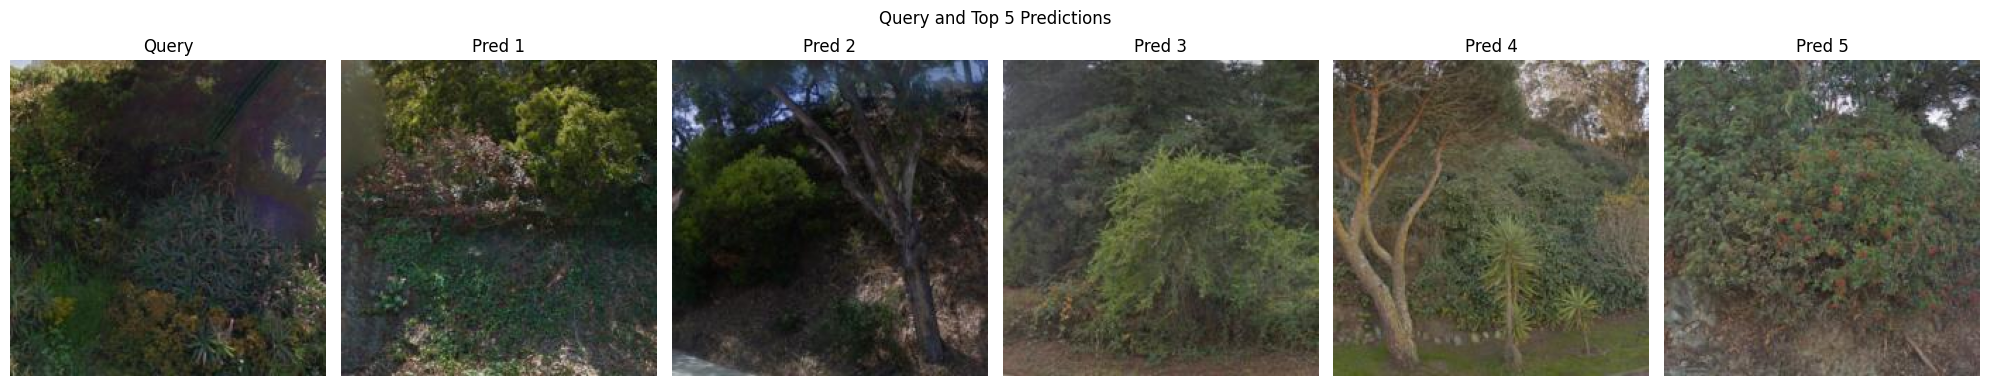

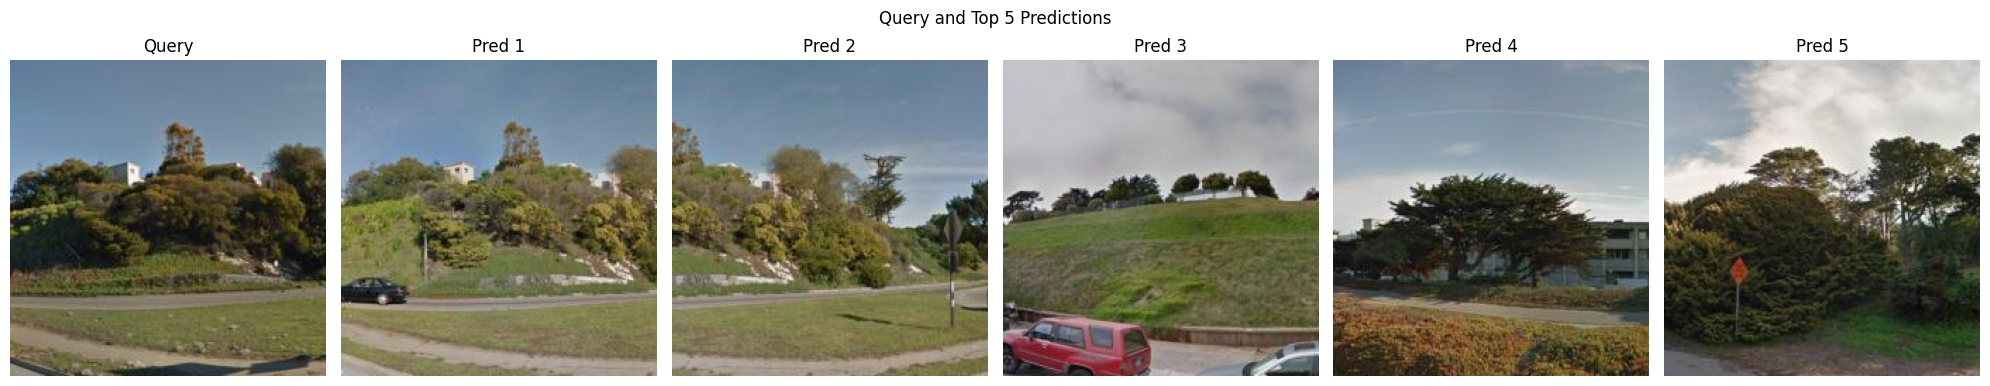

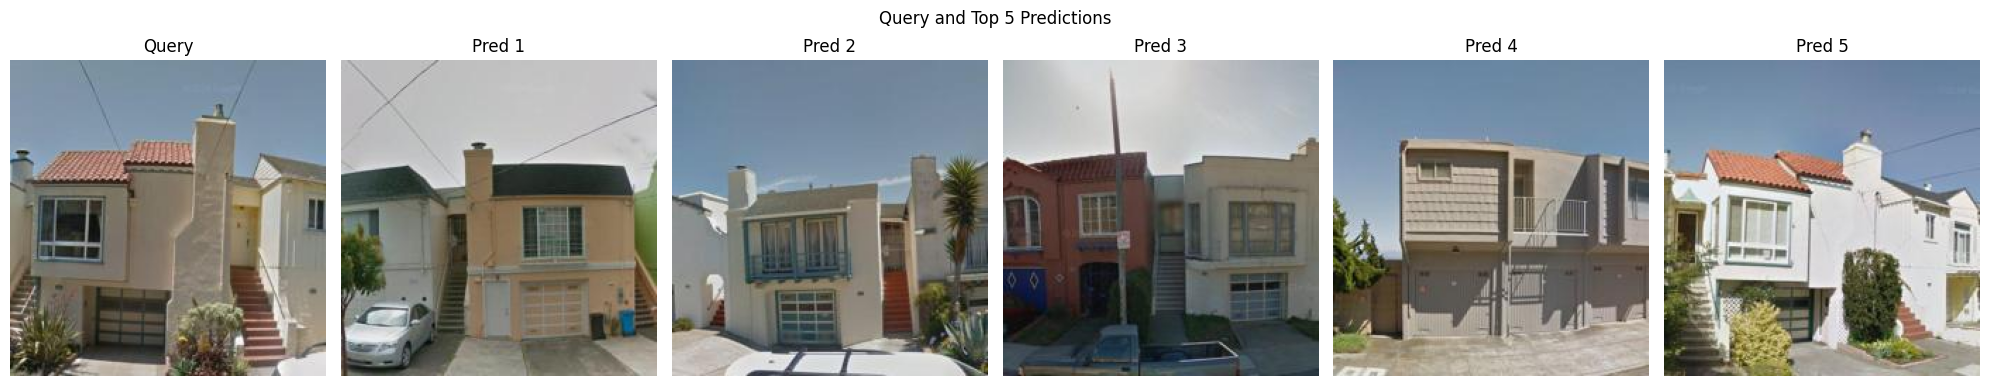

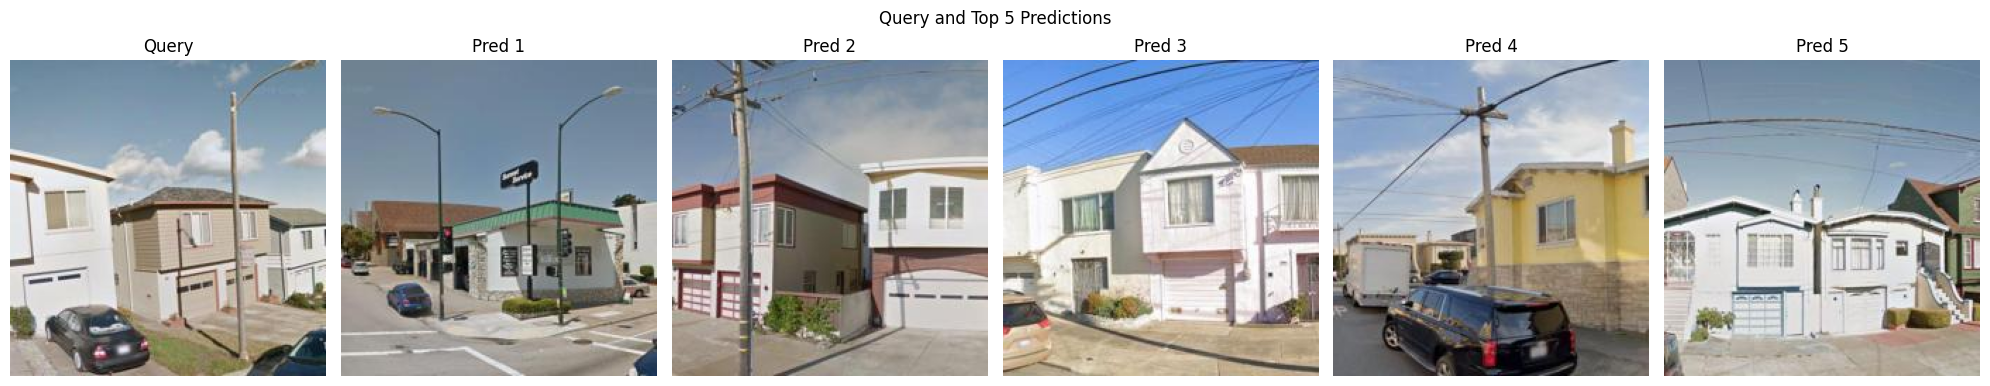

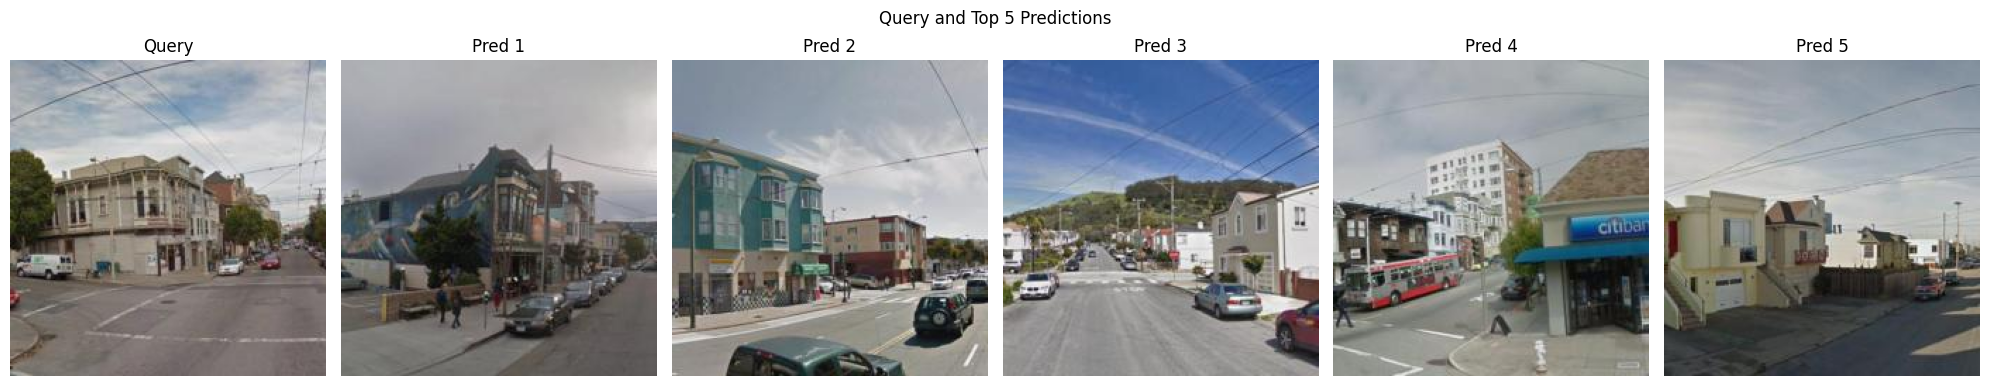

In [66]:
import random
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

def visualize_predictions(model, val_dataset, num_queries=5, top_k=5):
    # Set the model to evaluation mode
    model.eval()
    
    # Get all descriptors
    all_descriptors = []
    with torch.no_grad():
        for batch in val_loader:
            images, _ = batch
            descriptors = model(images.to(model.device))
            all_descriptors.append(descriptors.cpu().numpy())
    
    all_descriptors = np.concatenate(all_descriptors)
    queries_descriptors = all_descriptors[val_dataset.database_num:]
    database_descriptors = all_descriptors[:val_dataset.database_num]

    # Use FAISS for efficient similarity search
    faiss_index = faiss.IndexFlatL2(queries_descriptors.shape[1])
    faiss_index.add(database_descriptors)

    # Select random query indices
    query_indices = random.sample(range(val_dataset.queries_num), num_queries)

    # For each query, find the top-k similar images
    for query_idx in query_indices:
        query_descriptor = queries_descriptors[query_idx].reshape(1, -1)
        distances, indices = faiss_index.search(query_descriptor, top_k)

        # Prepare the plot
        fig, axs = plt.subplots(1, top_k + 1, figsize=(20, 4))
        fig.suptitle(f"Query and Top {top_k} Predictions")

        # Display the query image
        query_path = val_dataset.queries_paths[query_idx]
        query_img = Image.open(query_path)
        axs[0].imshow(query_img)
        axs[0].set_title("Query")
        axs[0].axis('off')

        # Display the top-k predictions
        for i, db_idx in enumerate(indices[0]):
            db_path = val_dataset.database_paths[db_idx]
            db_img = Image.open(db_path)
            axs[i+1].imshow(db_img)
            axs[i+1].set_title(f"Pred {i+1}")
            axs[i+1].axis('off')

        plt.tight_layout()
        plt.show()

# After training, call the visualization function
print("Training Process\n")
trainer.fit(model=model, ckpt_path=None, train_dataloaders=train_loader, val_dataloaders=val_loader)
print("VALIDATING ON SF")

# Load the best model after training
best_model = LightningModel.load_from_checkpoint(checkpoint_cb.best_model_path, val_dataset=sf_val_dataset, test_dataset=sf_test_dataset)

print("Visualizing predictions")
visualize_predictions(best_model, sf_val_dataset)